## Modulated Gold codes
This file can be used to load in the data from Thielen et al. (2021) which can be found at https://data.donders.ru.nl/collections/di/dcc/DSC_2018.00122_448?3.
The pipeline is identical to the other file, except for the data loading and the plotting of the average spatial filter.

In [12]:
from matplotlib.patches import Circle, Ellipse, Polygon
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import scipy.io
from sklearn.cross_decomposition import CCA

In [28]:
def topoplot(z, c="nt_cap8.loc", cbar=False, ax=None):
    """
    Function to plot a topoplot given the values at each electrode `z` and the electrode position file `c` that 
    denotes the electrode positions in polar coordinates.
    
    Args:
        z (numpy.ndarray): array of electrode values
        c (str): txt file containing electrode position information
        cbar (bool): whether or not to add a colorbar (default: False)
    """
    
    # Read electrode positions
    with open(c) as fid:
        lines = fid.read().split("\n")
        xy = np.zeros((len(lines), 2))
        for i, line in enumerate(lines):
            __, t, r, __ = line.split("\t")
            t = (float(t) + 90) / 180 * np.pi
            r = float(r) * 2
            xy[i, :] = r*np.cos(t), r*np.sin(t)
            
    # Add additional points for interpolation to edge of head
    xy = np.concatenate((xy, np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])), axis=0)
    z = np.concatenate((z, np.zeros((4,))), axis=None)

    # Make grid
    N = 300
    xi = np.linspace(-2, 2, N)
    yi = np.linspace(-2, 2, N)
    zi = griddata((xy[:, 0], xy[:, 1]), z, (xi[None,:], yi[:,None]), method="cubic", fill_value="nan")

    # Set points outside radius to nan so they will not be plotted (outside head).
    d = xi[1] - xi[0]
    for i in range(N):
        for j in range(N):
            if np.sqrt(xi[i]**2 + yi[j]**2) + d > 1:
                zi[j, i] = "nan"

    # Make figure
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, aspect=1)
    
    # Add head
    circle = Circle(xy=[0,0], radius=1, edgecolor="k", facecolor="w", zorder=1)
    ax.add_patch(circle)

    # Add ears
    circle = Ellipse(xy=[-1,0], width=0.25, height=0.5, angle=0, edgecolor="k", facecolor="w", zorder=0)
    ax.add_patch(circle)
    circle = Ellipse(xy=[1,0], width=0.25, height=0.5, angle=0, edgecolor="k", facecolor="w", zorder=0)
    ax.add_patch(circle)

    # Add a nose
    polygon = Polygon(xy=[[-0.1,0.9], [0,1.25],[0.1,0.9]], edgecolor="k", facecolor="w", zorder=0)
    ax.add_patch(polygon) 

    # Add the interpolated data
    cs = ax.contourf(xi, yi, zi, 60, cmap=plt.cm.RdYlBu_r, zorder=2)
    
    # Add iso-lines
    #ax.contour(xi, yi, zi, 15, colors="grey", zorder=3)

    # Add data points
    ax.scatter(xy[:-4,0], xy[:-4,1], marker="o", c="k", s=15, zorder=4)
    
    # Add color bar
    if cbar:
        bar = fig.colorbar(cs, ax=ax)
        bar.set_label('Filter coefficient',size=15)

    # Make the axis invisible 
    ax.axis("off")

    # set axes limits
    ax.set_xlim(1.25, -1.25)
    ax.set_ylim(-1.05, 1.4)
    ax.set_aspect(1.0)
    
    ax.set_title("Contrast \nAverage spatial filter", fontsize=15)
    
# Visualizes the EEG data in X 
def inspectEEGData(i_trial):
    plt.figure(figsize=(15, 5))
    plt.plot(np.arange(0, n_samples) / fs, 25 * np.arange(n_channels) + X[:, :, i_trial].T)
    plt.yticks(25 * np.arange(n_channels), channels)
    plt.xlabel("time [sec]")
    plt.ylabel("channel")
    plt.title(f"Single-trial multi-channel EEG time-series (trial {i_trial})")
    
    plt.figure(figsize=(15, 5))
    plt.plot(np.arange(0, n_samples) / fs, 25 * np.arange(n_channels) + X[:, :, i_trial].T)
    plt.yticks(25 * np.arange(n_channels), channels)
    plt.xlabel("time [sec]")
    plt.ylabel("channel")
    plt.title(f"Single-trial multi-channel EEG time-series (zoomed in) (trial {i_trial})")
    plt.xlim([0, 2.1])

# Shows the distribution of labels in y
def inspectLabels():
    plt.figure(figsize=(15, 3))
    hist = np.histogram(y, bins=np.arange(n_classes+1))[0]
    plt.bar(np.arange(n_classes), hist)
    plt.xticks(np.arange(n_classes))
    plt.xlabel("label")
    plt.ylabel("count")
    plt.title("Single-trial labels")

# Visualizes the codes in V
def inspectCodes():
    plt.figure(figsize=(15, 5))
    plt.plot(np.arange(0, V.shape[0]) / fs, 2 * np.arange(n_classes) + V)
    plt.yticks(2 * np.arange(n_classes), np.arange(n_classes))
    plt.xlabel("time [sec]")
    plt.ylabel("code")
    plt.title("Code time-series")

# Returns the number of unique flash lengths
def getNumberOfEvents(i_class):
    nrOfEvents = 0
    for i in range(E.shape[1]):
        if not (np.all(E[:, i, i_class] == 0, axis=0)):
            nrOfEvents = nrOfEvents + 1
    return nrOfEvents

# Generates E for the duration event-type
def eventDuration(): 
    for i_class in range(n_classes):
        up = np.where(rise[:, i_class])[0]
        down = np.where(fall[:, i_class])[0]
        if up.size > down.size:
            down = np.append(down, V.shape[0])
        durations = down - up
        unique_durations = np.unique(durations)  
        for i in range(nrOfEvents):
            E[up, i, i_class] = durations == unique_durations[i]

# Generates E for the simple event-type
def eventSimple():
    for i_class in range(n_classes):
        for i in range(1800):
            for j in range(90):
                if not i%10 == 0:
                    E[i, 0, j] = 0

# Generates E for the contrast event-type
def eventContrast():
    for i_class in range(n_classes):
        up = np.where(rise[:, i_class])[0]
        down = np.where(fall[:, i_class])[0]   
        E[up, 0, i_class] = True
        E[down, 1, i_class] = True

# Plots the code and events in E   
def plotEventTimeseries(nrOfEvents, labels, i_class):
    positions = np.zeros(nrOfEvents+1)
                      
    plt.figure(figsize=(15,10))
    plt.plot(np.arange(0, V.shape[0]) / fs, V[:, i_class])
    
    nextPosition = 0
    for i in range(E.shape[1]):
        plt.plot(np.arange(0, V.shape[0]) / fs, ((nextPosition+1)*1.5)+E[:, i, i_class])
        nextPosition = nextPosition + 1
            
    for i in range(nrOfEvents+1):
        positions[i] = (1.5*i) + 0.5
            
    labels = np.insert(labels, 0, "code")
    
    plt.yticks(positions, (labels))
    plt.xlabel("time [sec]")
    plt.ylabel("")
    plt.title(f"Event timeseries")     

# Visualizes the event matrix E
def plotEventMatrix(i_class):
    plt.figure(figsize=(15, 3))
    plt.imshow(E[:, :, i_class].T, cmap="gray", origin="lower")
    plt.gca().set_aspect(10)
    plt.xticks(np.arange(0, V.shape[0], 60), np.arange(0, V.shape[0], 60) / fs)
    plt.xlabel("time [sec]")
    plt.title(f"Event matrix (class {i_class})")

# Returns an array of size v*w containing the correlations between v and w    
def getCorrelations(v, w):
    for i in range(v.shape[1]):
        v[:, i] = v[:, i] - np.mean(v[:, i])
    for i in range(w.shape[1]):
        w[:, i] = w[:, i] - np.mean(w[:, i])
    return np.matmul(v.T, w) / np.sqrt(np.matmul(np.sum(v**2, axis=1).T, np.sum(w**2, axis=1))) 
    


subject 1 auto_cor
0.000
subject 1 cross_cor
0.000
Subject 1 accuracy
98.000

subject 2 auto_cor
0.313
subject 2 cross_cor
0.012
Subject 2 accuracy
67.000

subject 3 auto_cor
0.090
subject 3 cross_cor
0.014
Subject 3 accuracy
100.000

subject 4 auto_cor
0.230
subject 4 cross_cor
0.012
Subject 4 accuracy
88.000

subject 5 auto_cor
0.150
subject 5 cross_cor
0.013
Subject 5 accuracy
91.000

subject 6 auto_cor
0.147
subject 6 cross_cor
0.012
Subject 6 accuracy
97.000

subject 7 auto_cor
0.251
subject 7 cross_cor
0.014
Subject 7 accuracy
100.000

subject 8 auto_cor
0.268
subject 8 cross_cor
0.013
Subject 8 accuracy
91.000

subject 9 auto_cor
0.129
subject 9 cross_cor
0.013
Subject 9 accuracy
99.000

subject 10 auto_cor
0.241
subject 10 cross_cor
0.013
Subject 10 accuracy
16.000

subject 11 auto_cor
0.029
subject 11 cross_cor
0.013
Subject 11 accuracy
74.000

subject 12 auto_cor
0.088
subject 12 cross_cor
0.015
Subject 12 accuracy
65.000

subject 13 auto_cor
0.090
subject 13 cross_cor
0.012

<ipython-input-24-6aa43dd390c1>:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 2, figsize=(15, 3))



subject 21 auto_cor
0.067
subject 21 cross_cor
0.011
Subject 21 accuracy
98.000

subject 22 auto_cor
0.335
subject 22 cross_cor
0.011
Subject 22 accuracy
100.000

subject 23 auto_cor
0.545
subject 23 cross_cor
0.015
Subject 23 accuracy
70.000

subject 24 auto_cor
0.068
subject 24 cross_cor
0.012
Subject 24 accuracy
90.000

subject 25 auto_cor
0.177
subject 25 cross_cor
0.013
Subject 25 accuracy
92.000

subject 26 auto_cor
0.234
subject 26 cross_cor
0.022
Subject 26 accuracy
42.000

subject 27 auto_cor
0.041
subject 27 cross_cor
0.010
Subject 27 accuracy
97.000

subject 28 auto_cor
0.231
subject 28 cross_cor
0.012
Subject 28 accuracy
94.000

subject 29 auto_cor
0.163
subject 29 cross_cor
0.012
Subject 29 accuracy
100.000

subject 30 auto_cor
0.460
subject 30 cross_cor
0.021
Subject 30 accuracy
70.000

Total auto_cor: 0.194
Total cross_cor: 0.013
Total accuracy: 83.667
auto_cor sd: 0.124
cross_cor sd: 0.003
accuracy sd: 19.702


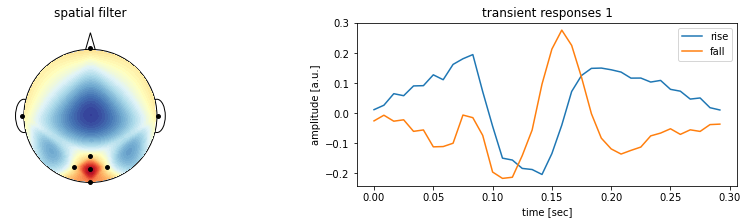

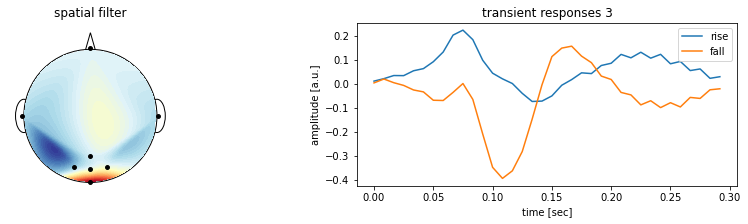

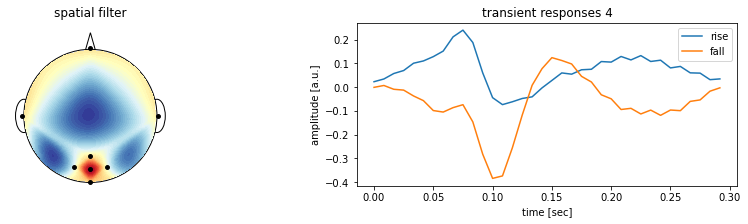

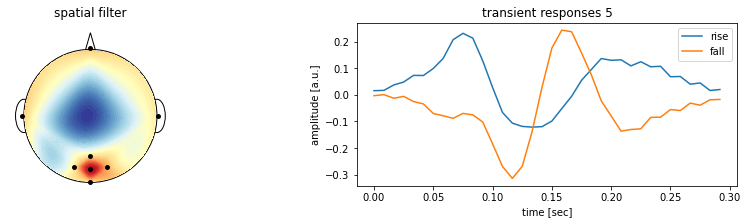

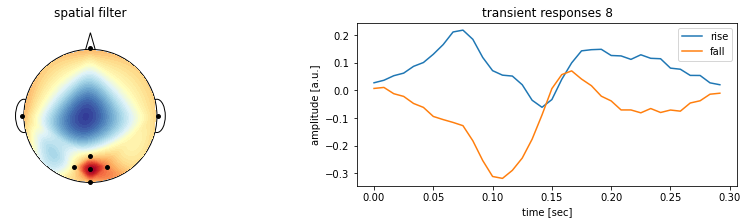

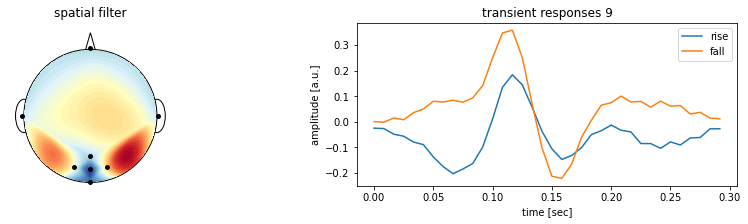

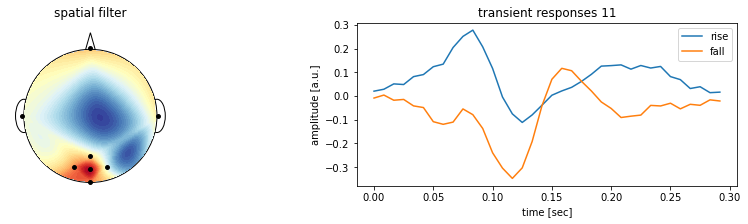

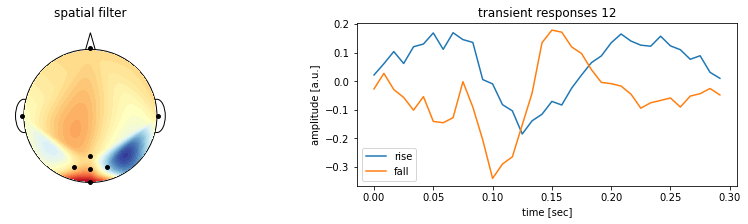

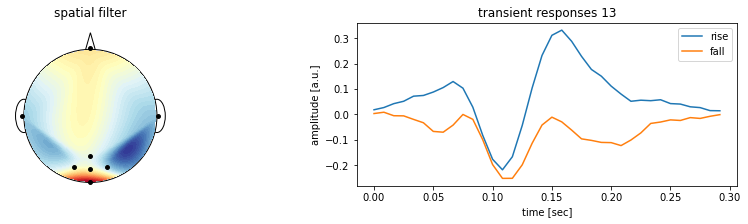

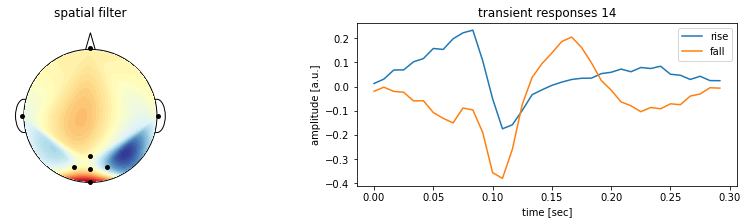

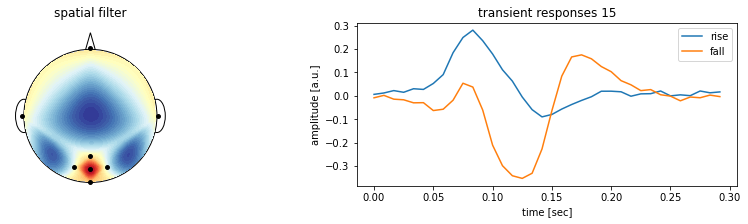

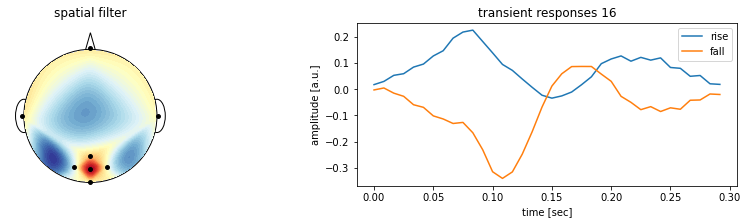

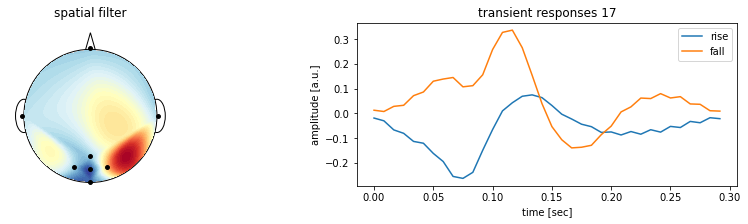

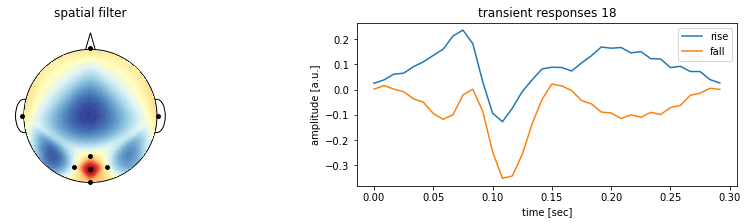

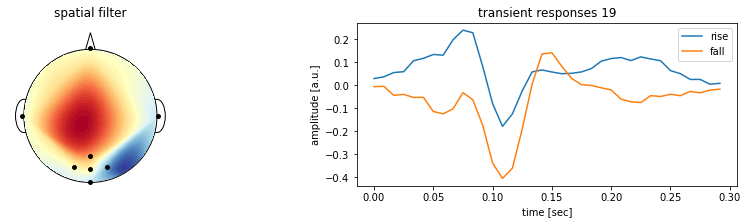

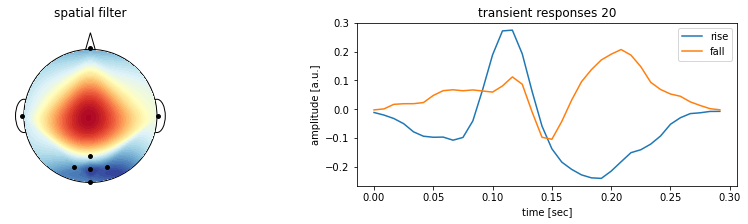

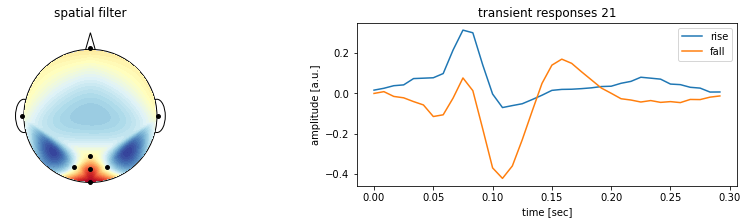

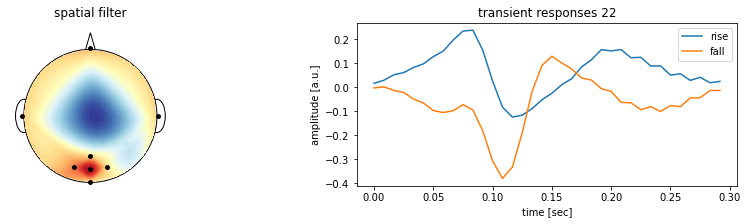

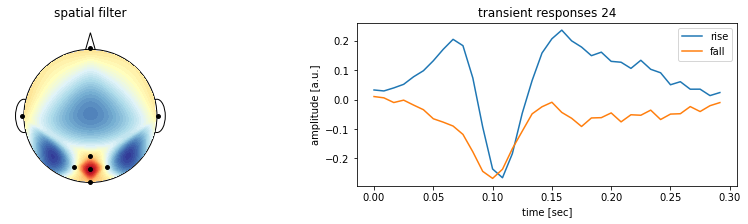

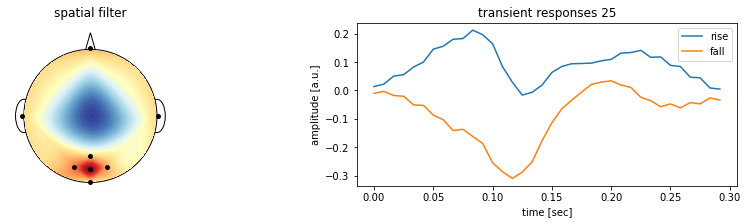

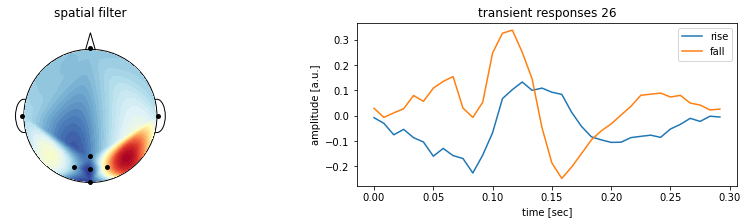

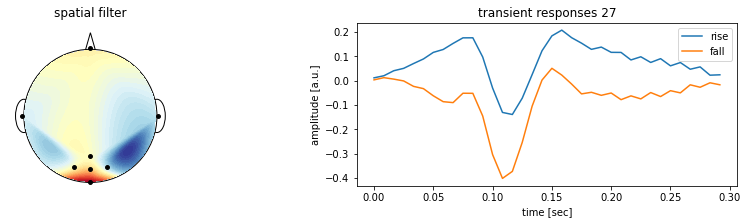

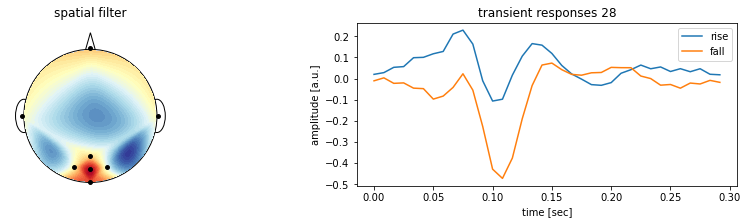

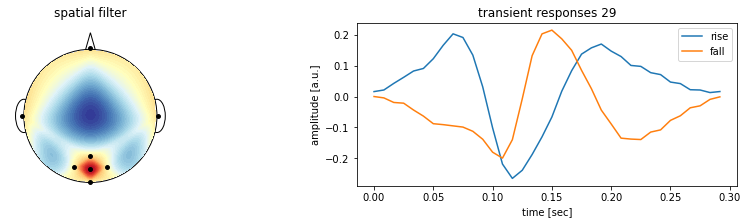

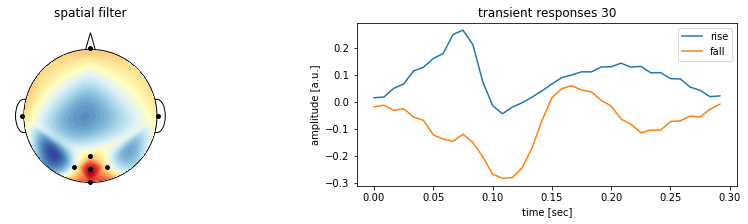

In [24]:
n_subjects = 30
n_folds = 10
nrOfEvents = 2
auto_cor = np.zeros((n_folds, n_subjects))
cross_cor = np.zeros((n_folds, n_subjects))
total_accuracy = np.zeros(n_subjects)
rAll = np.zeros((n_subjects, nrOfEvents*36))
wAll = np.zeros((n_subjects, 8))

for i_subject in range(1, n_subjects+1):

    # Load data
    fn = f"C:/Users/Julia/Downloads/Data/xsub-{i_subject}/xsub-{i_subject}_gdf.mat"
    tmp = scipy.io.loadmat(fn)
    X = tmp["X"].astype("float32")
    y = tmp["y"].flatten() - 1  # Note, minus one because matlab counts from 1, python from 0
    V = tmp["V"]
    fs = tmp["fs"][0][0]
 
    # Extract data dimensions
    n_channels, n_samples, n_trials = X.shape
    n_classes = V.shape[1]
 
    # Read cap file
    fn = "C:/Users/Julia/Downloads/Data/nt_cap8.txt"
    fid = open(fn, "r")
    channels = []
    for line in fid.readlines():
        channels.append(line.split()[0])
     
    # Get code rising and falling edges
    V = V.astype("bool_")
    Vr = np.roll(V, 1, axis=0)
    Vr[0, :] = False
    rise = np.logical_and(V, np.logical_not(Vr)).astype("uint8")
    fall = np.logical_and(np.logical_not(V), Vr).astype("uint8")
    
    # Create event matrix
    E = np.zeros((V.shape[0], nrOfEvents, V.shape[1]), dtype="uint8")
    eventContrast()
    
    # Create structure matrix
    n_samples_transient = int(0.3 * fs)
    M = np.zeros((V.shape[0], 0, V.shape[1]), dtype="uint8")

    for i_event in range(E.shape[1]):
        M_event = np.zeros((V.shape[0], n_samples_transient, V.shape[1]), dtype="uint8")
        M_event[:, 0, :] = E[:, i_event, :]

        for i_sample in range(1, n_samples_transient):
            M_event[:, i_sample, :] = np.roll(M_event[:, i_sample-1, :], 1, axis=0)
            M_event[0, i_sample, :] = 0

        M = np.concatenate((M, M_event), axis=1)
    
    # Reshape the data
    X_ = np.reshape(X, (n_channels, -1)).T
    
    # Repeat the structure matrices to full single-trial length
    M_ = np.tile(M, (15, 1, 1))
    
    # Set the structure matrices in the order of single-trials
    M_ = M_[:, :, y]
    
    # Reshape the structure matrix
    M_ = M_.transpose((1, 0, 2))
    M_ = np.reshape(M_, (nrOfEvents*n_samples_transient, -1)).T
    
    # Fit CCA
    cca = CCA(n_components=1)
    cca.fit(X_.astype("float32"), M_.astype("float32"))
    
    # Extract learned filters
    w = cca.x_weights_.flatten()
    r = cca.y_weights_.flatten()
    
    rAll[i_subject-1, :] = r
    wAll[i_subject-1, :] = w
    r_ = np.reshape(r, (nrOfEvents, n_samples_transient))
    
    # Plot CCA filters
    fig, ax = plt.subplots(1, 2, figsize=(15, 3)) 
    fn = "C:/Users/Julia/Downloads/Data/nt_cap8.loc"
    topoplot(w, fn, ax=ax[0])
    ax[0].set_title("spatial filter")
    for i in range(nrOfEvents):
        ax[1].plot(np.arange(n_samples_transient) / fs, r_[i, :])
    ax[1].legend(("rise", "fall"))
    ax[1].set_xlabel("time [sec]")
    ax[1].set_ylabel("amplitude [a.u.]")
    ax[1].set_title(f"transient responses {i_subject}")

    # Parameters
    n_samples = int(2.1 * fs)
    
    # Chronological folding
    n_folds = 10
    folds = np.repeat(np.arange(n_folds), n_trials / n_folds)
    
    # Loop folds
    accuracy = np.zeros(n_folds)
    spatial_filters = np.zeros((n_folds, n_channels))
    temporal_filters = np.zeros((n_folds, nrOfEvents*n_samples_transient))
    for i_fold in range(n_folds):
        
        # Split data into train and validation
        X_train = X[:, :n_samples, folds != i_fold]
        X_valid = X[:, :n_samples, folds == i_fold]
        y_train = y[folds != i_fold]
        y_valid = y[folds == i_fold]
        
        # Reshape the training data
        X_ = np.reshape(X_train, (n_channels, -1)).T
        M_ = np.tile(M, (np.ceil(n_samples/V.shape[0]), 1, 1))[:n_samples, :, :]
        M_ = M_[:, :, y_train]
        M_ = M_.transpose((1, 0, 2))
        M_ = np.reshape(M_, (nrOfEvents*n_samples_transient, -1)).T
    
        # Fit CCA using training data
        cca = CCA(n_components=1)
        cca.fit(X_.astype("float32"), M_.astype("float32"))
        w = cca.x_weights_.flatten()
        r = cca.y_weights_.flatten()
        spatial_filters[i_fold, :] = w
        temporal_filters[i_fold, :] = r
        
        # Predict templates
        T = np.zeros((M.shape[0], n_classes))
        for i_class in range(n_classes):
            T[:, i_class] = np.dot(M[:, :, i_class], r)
        T = np.tile(T, (np.ceil(n_samples/V.shape[0]), 1))[:n_samples, :]
        
        # Spatially filter validation data
        X_filtered = np.zeros((n_samples, y_valid.size))
        for i_trial in range(y_valid.size):
            X_filtered[:, i_trial] = np.dot(w, X_valid[:, :, i_trial])
        
        # Template matching
        prediction = np.zeros(y_valid.size)
        for i_trial in range(y_valid.size):
            rho = np.corrcoef(X_filtered[:, i_trial], T.T)[0, 1:]
            prediction[i_trial] = np.argmax(rho)
            
        # Compute explained variance   
        rho = getCorrelations(X_filtered, T)**2
        for i_trial in range(rho.shape[0]):    
            auto_cor[i_fold, i_subject-1] = auto_cor[i_fold, i_subject-1] + rho[i_trial, y_valid[i_trial]]
            cross_cor[i_fold, i_subject-1] = cross_cor[i_fold, i_subject-1] + (((sum(rho[i_trial, :])) - rho[i_trial, y_valid[i_trial]]) / (rho.shape[1]-1))                   
        auto_cor[i_fold, i_subject-1] = (auto_cor[i_fold, i_subject-1] / rho.shape[0])
        cross_cor[i_fold, i_subject-1] = (cross_cor[i_fold, i_subject-1] / rho.shape[0])
        
        
        # Compute accuracy
        accuracy[i_fold] = 100*np.mean(prediction == y_valid)
        total_accuracy[i_subject-2] = np.mean(accuracy)
        #print(f"classification accuracy {accuracy[i_fold]} percent ")
        #print(f"Prediction: {prediction}")
        #print(f"True: {y_valid}")

    # Print subject scores 
    print(f"\nsubject {i_subject} auto_cor")    
    print("{:.3f}".format(np.mean(auto_cor[:, i_subject-2])))
    print(f"subject {i_subject} cross_cor") 
    print("{:.3f}".format(np.mean(cross_cor[:, i_subject-2])))
    
    total_accuracy[i_subject-2] = np.mean(accuracy)
    print(f"Subject {i_subject} accuracy")
    print("{:.3f}".format(np.mean(accuracy)))
    
# Print total scores
print("\nTotal auto_cor: {:.3f}".format(np.mean(auto_cor)))
print("Total cross_cor: {:.3f}".format(np.mean(cross_cor)))
print("Total accuracy: {:.3f}".format(np.mean(total_accuracy)))

# Print standard deviations
print("auto_cor sd: {:.3f}".format(np.std(np.mean(auto_cor, axis = 0))))
print("cross_cor sd: {:.3f}".format(np.std(np.mean(cross_cor, axis = 0))))
print("accuracy sd: {:.3f}".format(np.std(total_accuracy)))






In [30]:
# Correcting CCA signs

rAll[8, :] = rAll[8, :] * -1
#rAll[16, :] = rAll[16, :] * -1
#rAll[19, :] = rAll[19, :] * -1
#rAll[25, :] = rAll[25, :] * -1


Text(0.5, 1.0, 'Modulated Gold + contrast event-type \n Average transient responses')

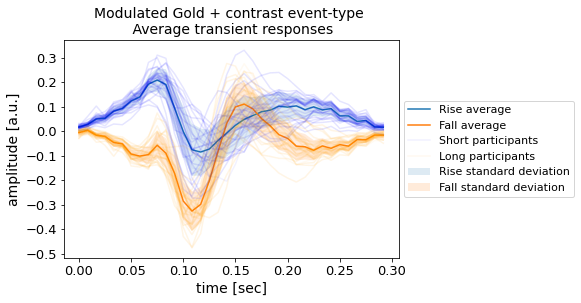

In [31]:
transientAvg = np.zeros((n_samples_transient*nrOfEvents))
transientStd = np.zeros((n_samples_transient*nrOfEvents))

for i in range(n_samples_transient*nrOfEvents):       
    transientAvg[i] = np.mean(rAll[:, i])
    transientStd[i] = np.std(rAll[:, i])

    avg_ = np.reshape(transientAvg, (nrOfEvents, n_samples_transient))
    std_ = np.reshape(transientStd, (nrOfEvents, n_samples_transient))
    
plt.plot(np.arange(n_samples_transient) / fs, avg_[0, :], label="Rise average")
plt.fill_between(np.arange(n_samples_transient) / fs, avg_[0, :]+std_[0, :], avg_[0, :]-std_[0, :], alpha=0.15, label="Rise standard deviation")
plt.plot(np.arange(n_samples_transient) / fs, avg_[1, :], label="Fall average")
plt.fill_between(np.arange(n_samples_transient) / fs, avg_[1, :]+std_[1, :], avg_[1, :]-std_[1, :], alpha=0.15, label="Fall standard deviation")

plt.plot(np.arange(n_samples_transient) / fs, np.reshape(rAll[0, :], (nrOfEvents, n_samples_transient))[0, :], alpha = 0.05, color='blue', label='Short participants')
plt.plot(np.arange(n_samples_transient) / fs, np.reshape(rAll[0, :], (nrOfEvents, n_samples_transient))[1, :], alpha = 0.05, color='orange', label='Long participants')
for i_subject in range(1, n_subjects):
    for i_event in range(nrOfEvents):
        plt.plot(np.arange(n_samples_transient) / fs, np.reshape(rAll[i_subject, :], (nrOfEvents, n_samples_transient))[0, :], alpha = 0.05, color='blue')
        plt.plot(np.arange(n_samples_transient) / fs, np.reshape(rAll[i_subject, :], (nrOfEvents, n_samples_transient))[1, :], alpha = 0.05, color='orange')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=11)
plt.xlabel("time [sec]", fontsize=14)
plt.ylabel("amplitude [a.u.]", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title("Modulated Gold + contrast event-type \n Average transient responses", fontsize=14)

#plt.savefig('Result gold contrast.pdf', bbox_inches='tight')

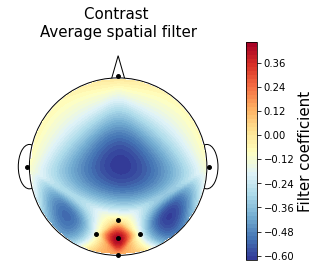

In [29]:
wAvg = np.zeros((8))
wStd = np.zeros((8))
for i in range(8):       
    wAvg[i] = np.mean(wAll[:, i])
    wStd[i] = np.std(wAll[:, i])
    

topoplot(wAvg, fn, cbar=True)

#plt.savefig('Result spatial gold contrast.pdf', bbox_inches='tight')